In [7]:
import os
import glob 
import pandas as pd

pattern = os.path.join('..', 'data', 'prepared', '*.csv')
files = glob.glob(pattern)
df = pd.read_csv(files[1], sep=';')
df2 = pd.read_csv(files[0], sep=';')

def safe_int_conversion(x):
    try:
        return int(x)
    except (ValueError, TypeError):
        return None

def compute_code_insee(row):
    code_dept = safe_int_conversion(row['Code departement'])
    code_commune = safe_int_conversion(row['Code commune'])
    if code_dept is not None and code_commune is not None:
        return str((code_dept * 1000) + code_commune).zfill(5)
    return '00000'

df['Code insee'] = df.apply(compute_code_insee, axis=1)

df_data = pd.DataFrame()
cols_to_keep = [
    'Valeur fonciere',
    'Surface reelle bati', 
    'Nombre pieces principales', 
    'Surface terrain', 
    'Code insee'
]
df_data = df[cols_to_keep]

df2_data = pd.DataFrame()
col_to_keep = [
    'code_insee',
    'population',
    'superficie_km2',
    'densite',
    'niveau_equipements_services',
    'latitude_centre',
    'longitude_centre',
    'altitude_moyenne'
]
df2_data = df2[col_to_keep]

df_merged = pd.merge(df_data, df2_data, left_on='Code insee', right_on='code_insee')
df_merged.drop(columns=['Code insee', 'code_insee'], inplace=True)
df_merged.dtypes

Valeur fonciere                  int64
Surface reelle bati              int64
Nombre pieces principales        int64
Surface terrain                  int64
population                       int64
superficie_km2                   int64
densite                        float64
niveau_equipements_services    float64
latitude_centre                float64
longitude_centre               float64
altitude_moyenne                 int64
dtype: object

In [8]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284139 entries, 0 to 284138
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Valeur fonciere              284139 non-null  int64  
 1   Surface reelle bati          284139 non-null  int64  
 2   Nombre pieces principales    284139 non-null  int64  
 3   Surface terrain              284139 non-null  int64  
 4   population                   284139 non-null  int64  
 5   superficie_km2               284139 non-null  int64  
 6   densite                      284139 non-null  float64
 7   niveau_equipements_services  284139 non-null  float64
 8   latitude_centre              284139 non-null  float64
 9   longitude_centre             284139 non-null  float64
 10  altitude_moyenne             284139 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 23.8 MB


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

y = df_merged['Valeur fonciere']
X = df_merged.drop(columns=['Valeur fonciere'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42))
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)

r2 = r2_score(y_valid, preds)
print(f"R2 = {r2:.4f}")

R2 = 0.4374


In [10]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

y = df_merged['Valeur fonciere']
X = df_merged.drop(columns=['Valeur fonciere'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(random_state=42))
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)

r2 = r2_score(y_valid, preds)
print(f"R2 = {r2:.4f}")

R2 = 0.3627


### On va analyser l'importance des features

In [11]:
# Récupérer les importances des features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': pipeline.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.head(10))

                       feature  importance
3                   population    0.225829
5                      densite    0.213379
2              Surface terrain    0.164081
0          Surface reelle bati    0.101730
4               superficie_km2    0.063457
1    Nombre pieces principales    0.060516
7              latitude_centre    0.055283
8             longitude_centre    0.053830
9             altitude_moyenne    0.052521
6  niveau_equipements_services    0.009375


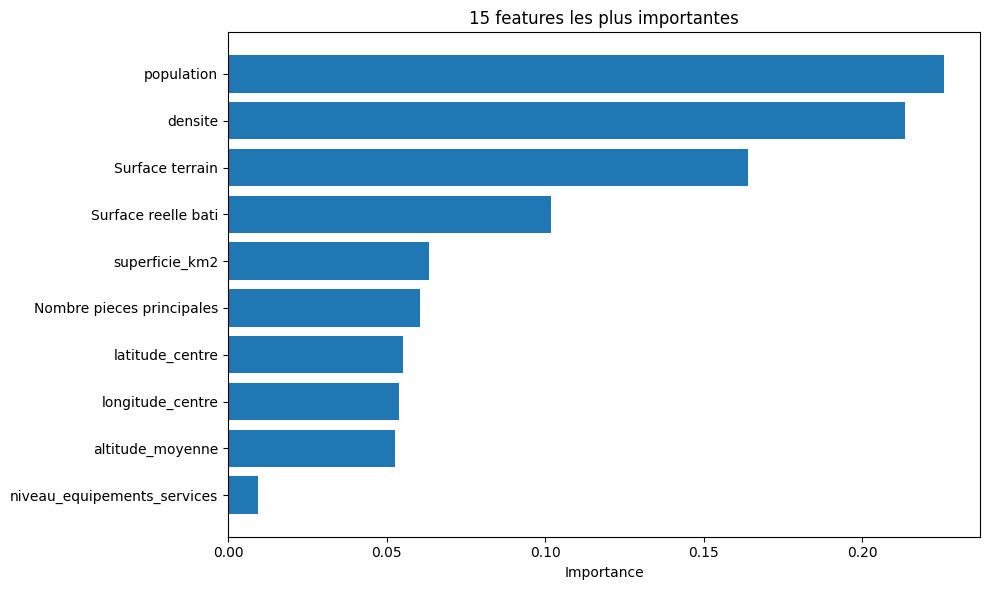

In [12]:
# Visualisation de l'importance des features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(15), feature_importance['importance'].head(15))
plt.xlabel('Importance')
plt.title('15 features les plus importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Maintenant on regarde la repartirion de 'Valeur fonciere'

Visualisation des outliers pour la variable Valeur fonciere

Min: 5, Max: 540000
Médiane: 161000.0, Moyenne: 182184.52741450781


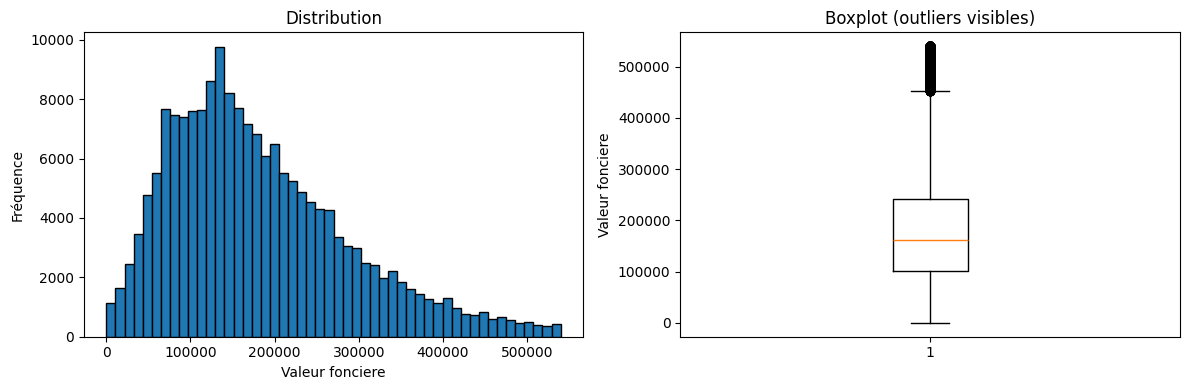

In [34]:
def visu_outliers(y): 

    print(f"Visualisation des outliers pour la variable {y.name}")
    # Statistiques de base
    #print(y.describe())
    print(f"\nMin: {y.min()}, Max: {y.max()}")
    print(f"Médiane: {y.median()}, Moyenne: {y.mean()}")

    # Visualiser la distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogramme
    axes[0].hist(y, bins=50, edgecolor='black')
    axes[0].set_xlabel(y.name)
    axes[0].set_ylabel('Fréquence')
    axes[0].set_title('Distribution')

    # Boxplot pour voir les outliers
    axes[1].boxplot(y)
    axes[1].set_ylabel(y.name)
    axes[1].set_title('Boxplot (outliers visibles)')

    plt.tight_layout()
    plt.show()

visu_outliers(y)

### Gestion des outliers

In [14]:
# Identifier les outliers avec la méthode IQR
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (y < lower_bound) | (y > upper_bound)
print(f"Nombre d'outliers : {outliers.sum()} / {len(y)} ({100*outliers.sum()/len(y):.1f}%)")

# Option 1 : Retirer les outliers
df_no_outliers = df_merged[~outliers]
y_clean = df_no_outliers['Valeur fonciere']
X_clean = df_no_outliers.drop(columns=['Valeur fonciere'])

# Tester sans outliers
X_train, X_valid, y_train, y_valid = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
preds_clean = pipeline.predict(X_valid)


r2_clean = r2_score(y_valid, preds_clean)
print(f"R2 sans outliers : {r2_clean:.4f}")

Nombre d'outliers : 17878 / 284139 (6.3%)
R2 sans outliers : 0.6248


In [15]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266261 entries, 0 to 284007
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Valeur fonciere              266261 non-null  int64  
 1   Surface reelle bati          266261 non-null  int64  
 2   Nombre pieces principales    266261 non-null  int64  
 3   Surface terrain              266261 non-null  int64  
 4   population                   266261 non-null  int64  
 5   superficie_km2               266261 non-null  int64  
 6   densite                      266261 non-null  float64
 7   niveau_equipements_services  266261 non-null  float64
 8   latitude_centre              266261 non-null  float64
 9   longitude_centre             266261 non-null  float64
 10  altitude_moyenne             266261 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 24.4 MB


count    266261.000000
mean     191064.100090
std      113394.161407
min           2.000000
25%      105000.000000
50%      169000.000000
75%      255830.000000
max      540000.000000
Name: Valeur fonciere, dtype: float64

Min: 2, Max: 540000
Médiane: 169000.0, Moyenne: 191064.10008976154


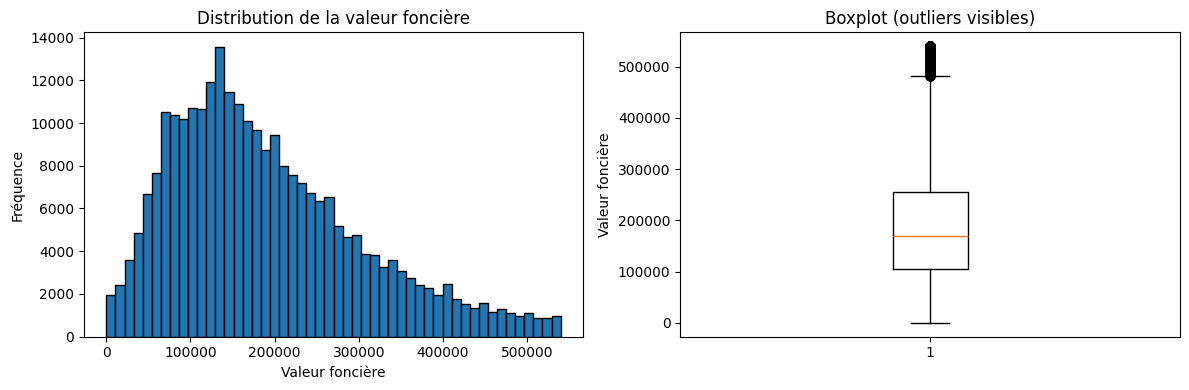

In [16]:
visu_outliers(y_clean)

### Ameliorations :
- il faudrait recalculer et retirer rer les outliers.
- Faire une separation par nombre de pieces car les px/m2 different selon le type mais aussi la taille.
- Faire une séparation maison/appartement.

In [17]:
X_train['Nombre pieces principales'].unique()

array([ 3,  2,  4,  5,  1,  6,  0,  7,  8, 10,  9, 11, 12, 25, 14, 13, 21,
       77, 83, 17, 16, 34, 30, 36, 82, 15, 20, 19])

In [18]:
df_merged[df_merged['Nombre pieces principales'] == 77]

,Valeur fonciere,Surface reelle bati,Nombre pieces principales,Surface terrain,population,superficie_km2,densite,niveau_equipements_services,latitude_centre,longitude_centre,altitude_moyenne
247541,177410,74,77,0,225081,50,4470.0,4.0,48.112,-1.682,38


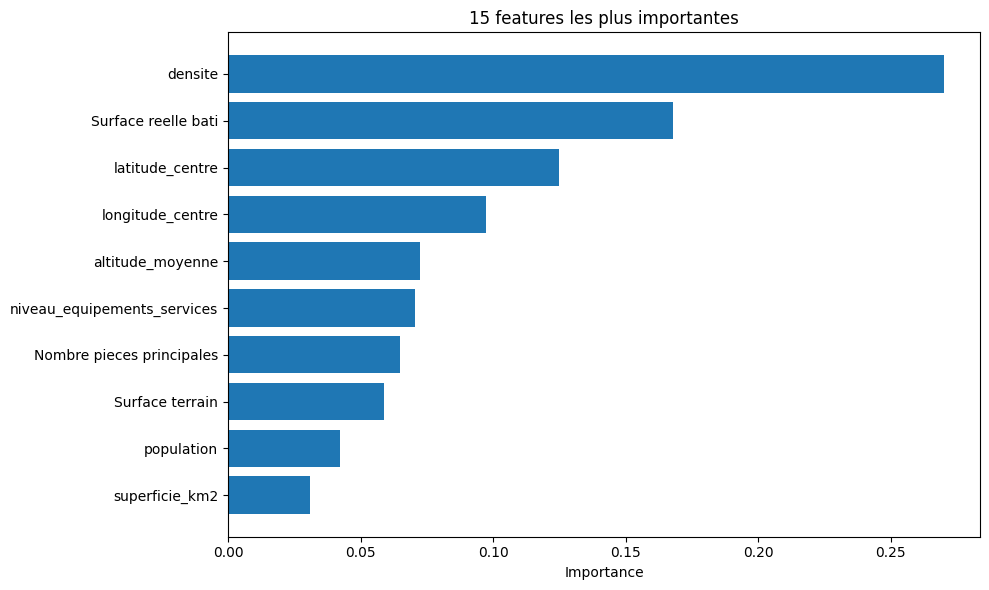

In [19]:
# Visualisation de l'importance des features

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': pipeline.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(15), feature_importance['importance'].head(15))
plt.xlabel('Importance')
plt.title('15 features les plus importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

count    284139.00000
mean          3.19432
std           1.66103
min           0.00000
25%           2.00000
50%           3.00000
75%           4.00000
max          83.00000
Name: Nombre pieces principales, dtype: float64

Min: 0, Max: 83
Médiane: 3.0, Moyenne: 3.194320385445152


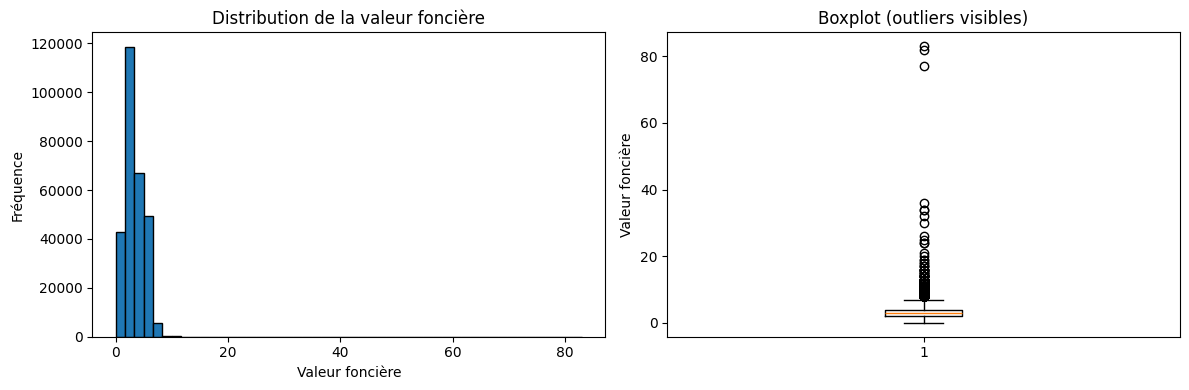

In [20]:
visu_outliers(X['Nombre pieces principales'])

count    284139.000000
mean         98.970873
std         707.264395
min           1.000000
25%          50.000000
50%          73.000000
75%          99.000000
max      303623.000000
Name: Surface reelle bati, dtype: float64

Min: 1, Max: 303623
Médiane: 73.0, Moyenne: 98.97087341054906


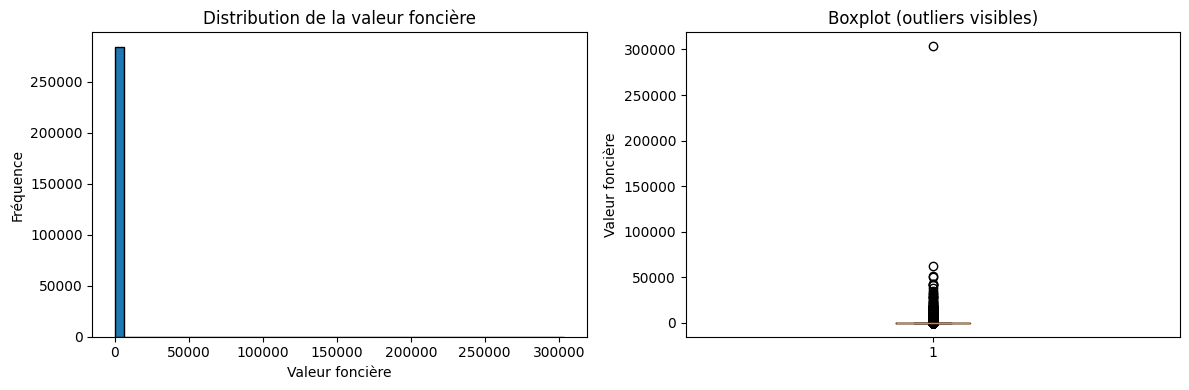

In [21]:
visu_outliers(X['Surface reelle bati'])

       Surface reelle bati  Nombre pieces principales  Surface terrain  \
count        284139.000000               284139.00000    284139.000000   
mean             98.970873                    3.19432       281.866812   
std             707.264395                    1.66103      1152.146982   
min               1.000000                    0.00000         0.000000   
25%              50.000000                    2.00000         0.000000   
50%              73.000000                    3.00000         0.000000   
75%              99.000000                    4.00000       400.000000   
max          303623.000000                   83.00000    263590.000000   

         population  superficie_km2        densite  \
count  2.841390e+05   284139.000000  284139.000000   
mean   1.454756e+05       36.928736    2870.419457   
std    4.231081e+05       48.301446    4835.520888   
min    1.000000e+01        0.000000       0.000000   
25%    3.301000e+03       10.000000     172.000000   
50%    1.

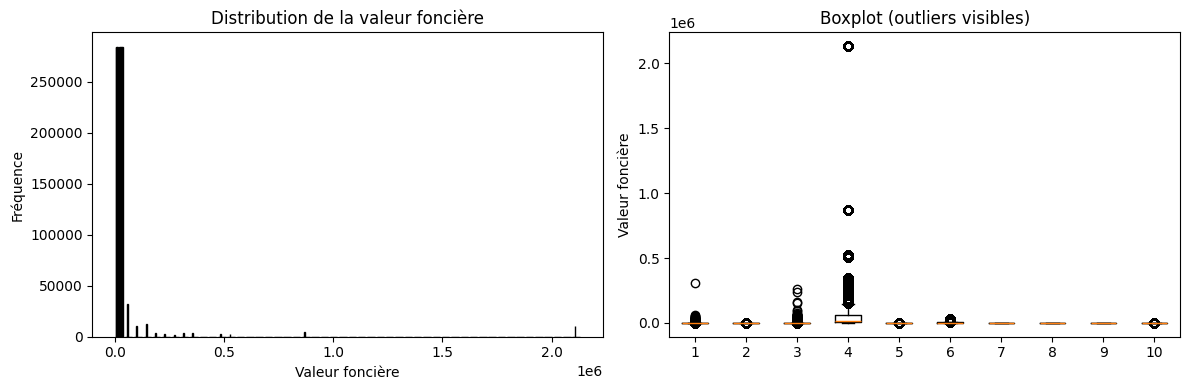

In [22]:
visu_outliers(X)

### Il va falloir recalculer les outliers pour chaqaue colonne par la methode IQR et les eliminer.

In [23]:
def calcul_outliers(y):
    # Identifier les outliers avec la méthode IQR
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (y < lower_bound) | (y > upper_bound)
    print(f"Nombre d'outliers : {outliers.sum()} / {len(y)} ({100*outliers.sum()/len(y):.1f}%)")

for col in X.columns:
    print(f"Analyse des outliers pour la colonne : {col}")
    calcul_outliers(X[col])
    


Analyse des outliers pour la colonne : Surface reelle bati
Nombre d'outliers : 11754 / 284139 (4.1%)
Analyse des outliers pour la colonne : Nombre pieces principales
Nombre d'outliers : 2189 / 284139 (0.8%)
Analyse des outliers pour la colonne : Surface terrain
Nombre d'outliers : 14630 / 284139 (5.1%)
Analyse des outliers pour la colonne : population
Nombre d'outliers : 40846 / 284139 (14.4%)
Analyse des outliers pour la colonne : superficie_km2
Nombre d'outliers : 26588 / 284139 (9.4%)
Analyse des outliers pour la colonne : densite
Nombre d'outliers : 23271 / 284139 (8.2%)
Analyse des outliers pour la colonne : niveau_equipements_services
Nombre d'outliers : 0 / 284139 (0.0%)
Analyse des outliers pour la colonne : latitude_centre
Nombre d'outliers : 0 / 284139 (0.0%)
Analyse des outliers pour la colonne : longitude_centre
Nombre d'outliers : 0 / 284139 (0.0%)
Analyse des outliers pour la colonne : altitude_moyenne
Nombre d'outliers : 23825 / 284139 (8.4%)


### On va traiter les outliers

In [24]:
import numpy as np

def traiter_outliers(df, cols=None, iqr_multiplier=1.5, drop=True, verbose=True):
    """
    Détecte et retire les outliers par colonne en utilisant la méthode IQR.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame d'entrée.
    cols : list or None
        Liste de colonnes à traiter. Si None, on prend les colonnes numériques.
    iqr_multiplier : float
        Multiplicateur IQR (1.5 par défaut).
    drop : bool
        Si True, retourne un nouveau DataFrame sans les lignes outliers. Si False, retourne le masque booléen des outliers.
    verbose : bool
        Affiche un résumé par colonne.

    Returns
    -------
    pd.DataFrame or pd.Series
        DataFrame nettoyé si drop=True sinon Series bool (True = outlier).
    """

    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(cols) == 0:
        if verbose:
            print("Aucune colonne numérique trouvée pour détecter les outliers.")
        return df.copy() if drop else pd.Series(False, index=df.index)

    # masque global qui sera True pour les lignes considérées outliers sur au moins une colonne
    outlier_mask = pd.Series(False, index=df.index)

    for col in cols:
        # calculs robustes en ignorant les NaN
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR

        mask = (df[col] < lower) | (df[col] > upper)
        outlier_mask = outlier_mask | mask

        if verbose:
            n_out = int(mask.sum())
            pct = 100 * n_out / len(df)
            print(f"Colonne '{col}': outliers = {n_out} / {len(df)} ({pct:.2f}%) | bounds=({lower:.2f}, {upper:.2f})")

    if drop:
        df_clean = df.loc[~outlier_mask].reset_index(drop=True)
        if verbose:
            print(f"\nTotal lignes supprimées : {int(outlier_mask.sum())} / {len(df)} ({100*outlier_mask.sum()/len(df):.2f}%)")
        return df_clean
    else:
        return outlier_mask

# Exemple d'utilisation :
# df_merged_clean = traiter_outliers(df_merged)
# ou pour obtenir le masque : mask = traiter_outliers(df_merged, drop=False)

print(len(df_merged))
df_merged_clean = traiter_outliers(df_merged)
print(len(df_merged_clean))

284139
Colonne 'Valeur fonciere': outliers = 17878 / 284139 (6.29%) | bounds=(-148000.00, 540000.00)
Colonne 'Surface reelle bati': outliers = 11754 / 284139 (4.14%) | bounds=(-23.50, 172.50)
Colonne 'Nombre pieces principales': outliers = 2189 / 284139 (0.77%) | bounds=(-1.00, 7.00)
Colonne 'Surface terrain': outliers = 14630 / 284139 (5.15%) | bounds=(-600.00, 1000.00)
Colonne 'population': outliers = 40846 / 284139 (14.38%) | bounds=(-84626.00, 149846.00)
Colonne 'superficie_km2': outliers = 26588 / 284139 (9.36%) | bounds=(-44.00, 100.00)
Colonne 'densite': outliers = 23271 / 284139 (8.19%) | bounds=(-5013.50, 8814.50)
Colonne 'niveau_equipements_services': outliers = 0 / 284139 (0.00%) | bounds=(-1.00, 7.00)
Colonne 'latitude_centre': outliers = 0 / 284139 (0.00%) | bounds=(37.62, 55.57)
Colonne 'longitude_centre': outliers = 0 / 284139 (0.00%) | bounds=(-5.39, 10.94)
Colonne 'altitude_moyenne': outliers = 23825 / 284139 (8.38%) | bounds=(-210.00, 446.00)

Total lignes supprimées 

Visualisation des outliers pour la variable Valeur fonciere
count    180689.000000
mean     182184.527415
std      106646.991983
min           5.000000
25%      102000.000000
50%      161000.000000
75%      242400.000000
max      540000.000000
Name: Valeur fonciere, dtype: float64

Min: 5, Max: 540000
Médiane: 161000.0, Moyenne: 182184.52741450781


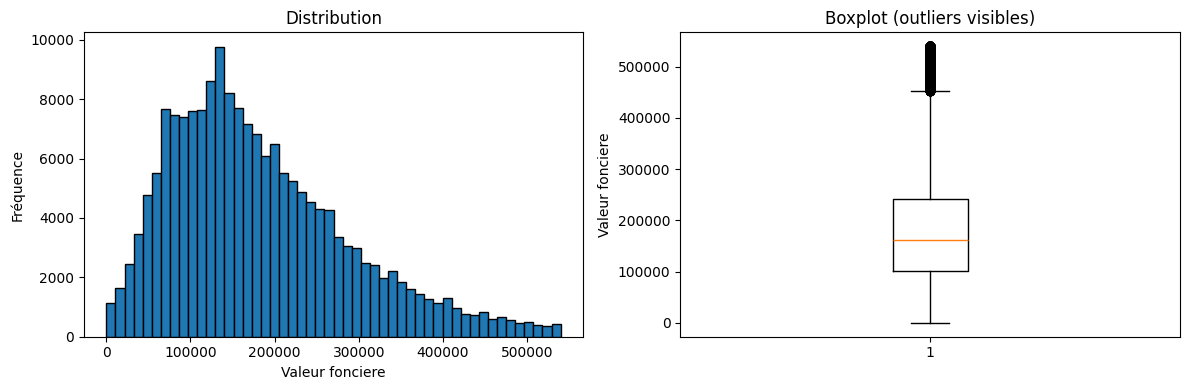

Visualisation des outliers pour la variable Surface reelle bati
count    180689.000000
mean         75.421597
std          31.544124
min           1.000000
25%          52.000000
50%          74.000000
75%          95.000000
max         172.000000
Name: Surface reelle bati, dtype: float64

Min: 1, Max: 172
Médiane: 74.0, Moyenne: 75.42159733021933


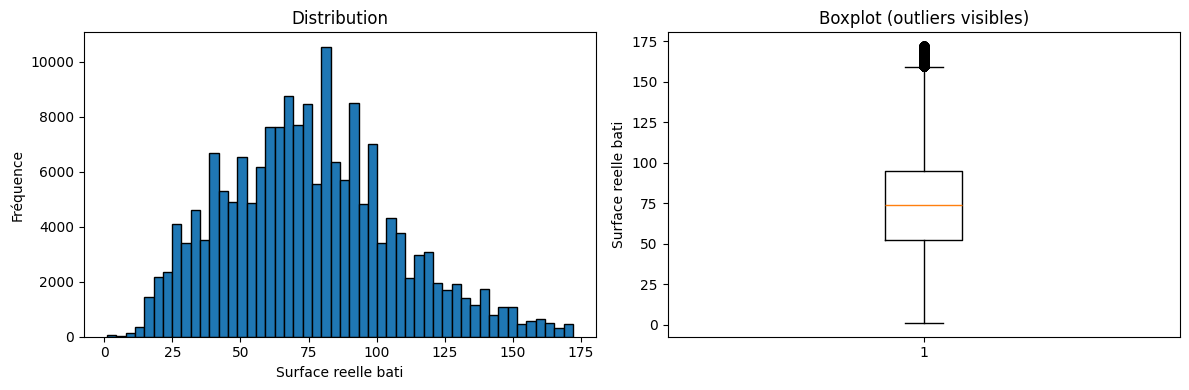

Visualisation des outliers pour la variable Nombre pieces principales
count    180689.000000
mean          3.289813
std           1.447852
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           7.000000
Name: Nombre pieces principales, dtype: float64

Min: 0, Max: 7
Médiane: 3.0, Moyenne: 3.2898128829093083


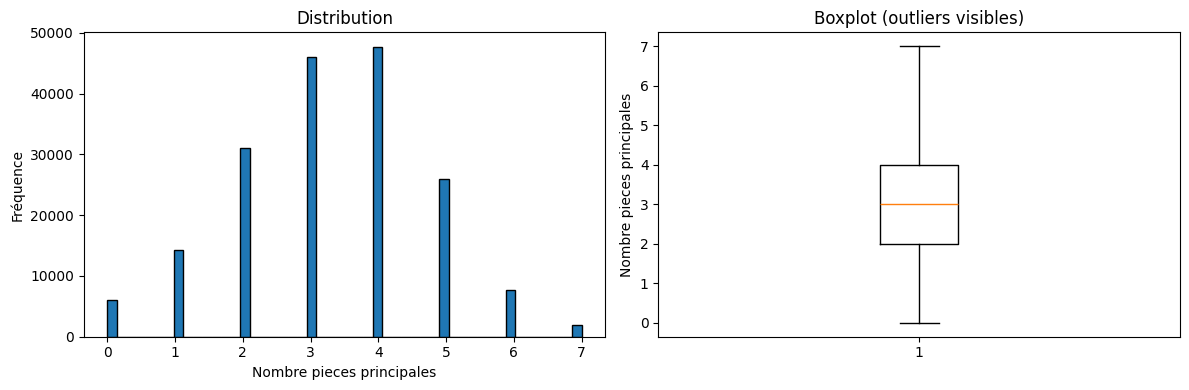

Visualisation des outliers pour la variable Surface terrain
count    180689.000000
mean        215.182324
std         272.143093
min           0.000000
25%           0.000000
50%          65.000000
75%         400.000000
max        1000.000000
Name: Surface terrain, dtype: float64

Min: 0, Max: 1000
Médiane: 65.0, Moyenne: 215.1823243252218


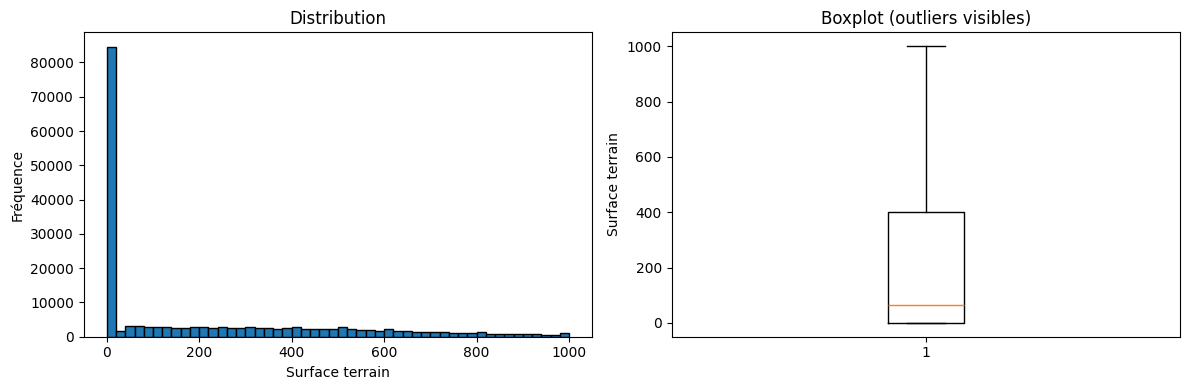

Visualisation des outliers pour la variable population
count    180689.000000
mean      24390.289735
std       32184.730934
min          18.000000
25%        3203.000000
50%       10369.000000
75%       32285.000000
max      147327.000000
Name: population, dtype: float64

Min: 18, Max: 147327
Médiane: 10369.0, Moyenne: 24390.28973540171


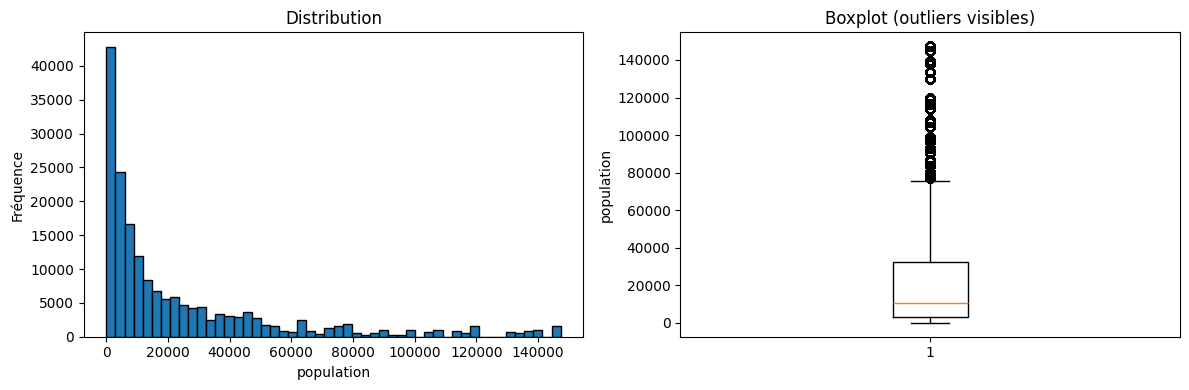

Visualisation des outliers pour la variable superficie_km2
count    180689.000000
mean         22.919143
std          19.347480
min           0.000000
25%           9.000000
50%          16.000000
75%          31.000000
max         100.000000
Name: superficie_km2, dtype: float64

Min: 0, Max: 100
Médiane: 16.0, Moyenne: 22.91914283658662


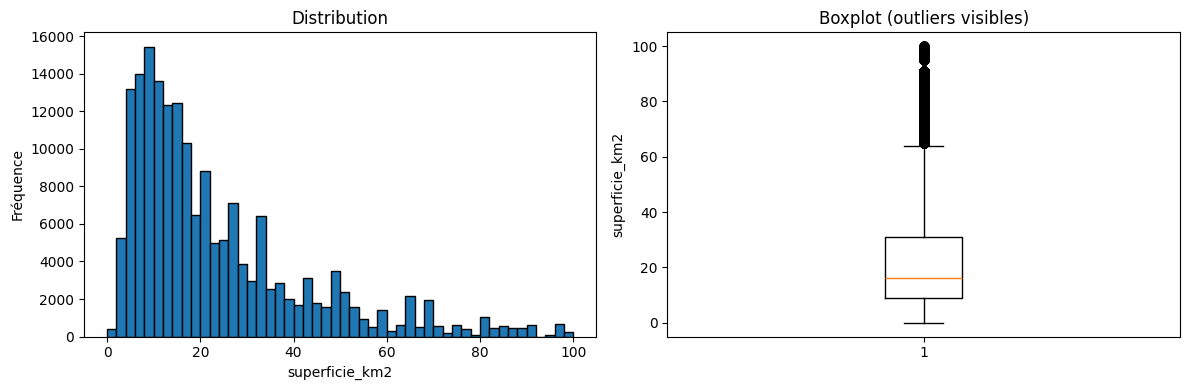

Visualisation des outliers pour la variable densite
count    180689.000000
mean       1437.931695
std        1797.607804
min           2.000000
25%         181.000000
50%         659.000000
75%        2020.000000
max        8640.000000
Name: densite, dtype: float64

Min: 2.0, Max: 8640.0
Médiane: 659.0, Moyenne: 1437.9316947904963


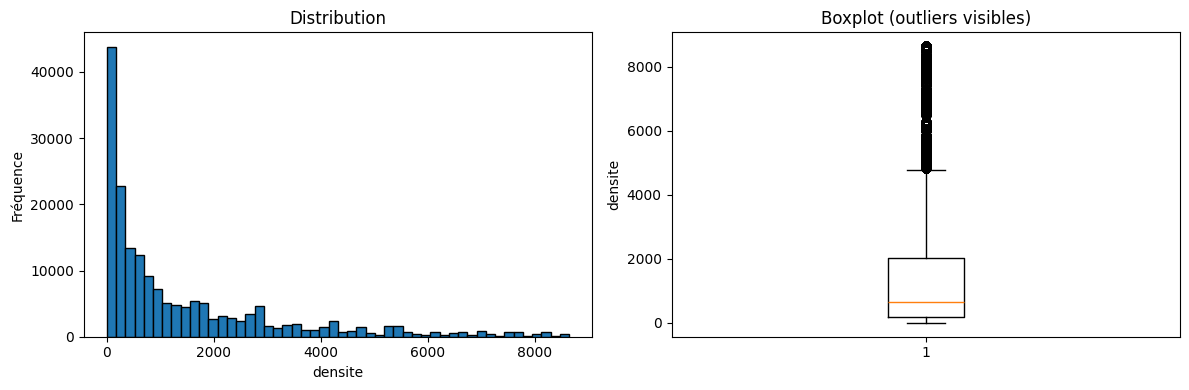

Visualisation des outliers pour la variable niveau_equipements_services
count    180689.000000
mean          2.303355
std           1.187940
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: niveau_equipements_services, dtype: float64

Min: 0.0, Max: 4.0
Médiane: 2.0, Moyenne: 2.303355489266087


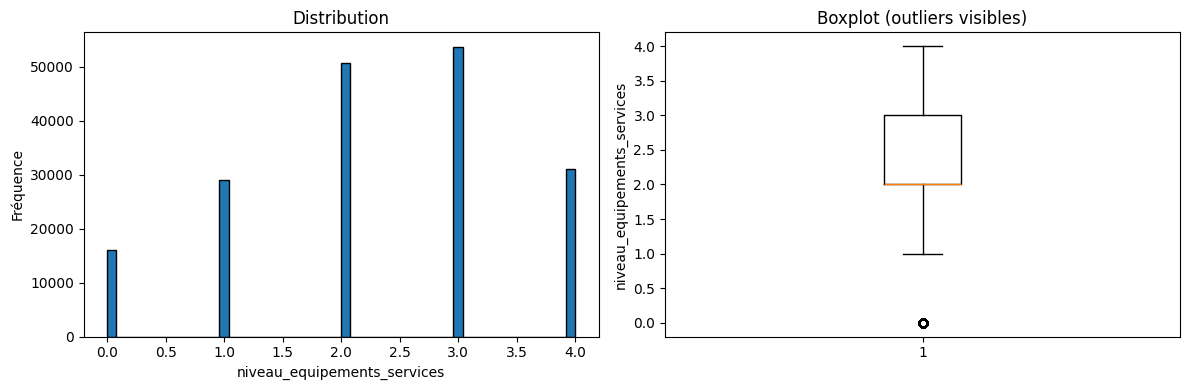

Visualisation des outliers pour la variable latitude_centre
count    180689.000000
mean         46.927685
std           2.367274
min          42.444000
25%          44.823000
50%          47.381000
75%          48.851000
max          51.073000
Name: latitude_centre, dtype: float64

Min: 42.444, Max: 51.073
Médiane: 47.381, Moyenne: 46.92768485630005


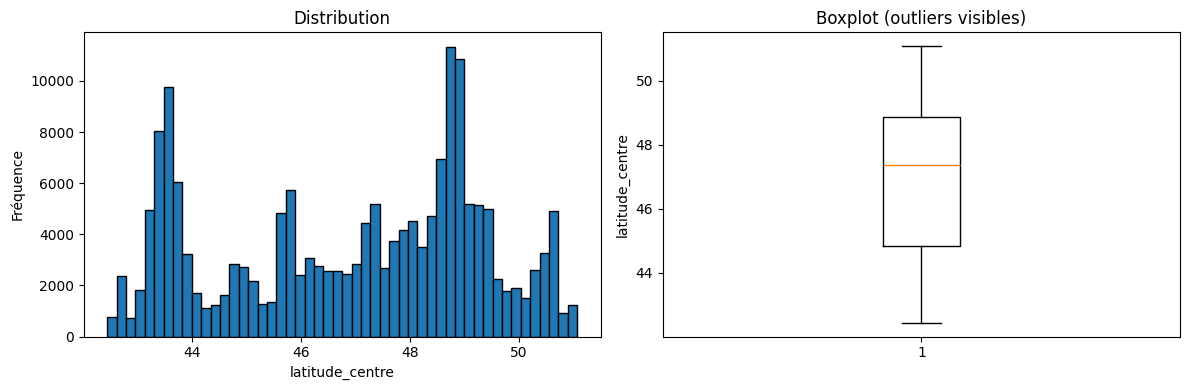

Visualisation des outliers pour la variable longitude_centre
count    180689.000000
mean          2.133449
std           2.687413
min          -5.085000
25%           0.166000
50%           2.356000
75%           4.071000
max           7.494000
Name: longitude_centre, dtype: float64

Min: -5.085, Max: 7.494
Médiane: 2.356, Moyenne: 2.1334488491275065


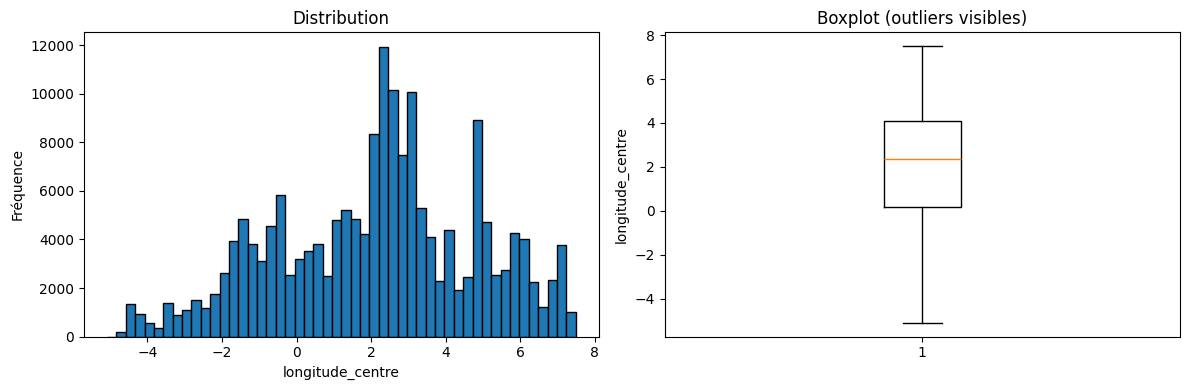

Visualisation des outliers pour la variable altitude_moyenne
count    180689.000000
mean        119.240485
std         103.866526
min           0.000000
25%          41.000000
50%          84.000000
75%         172.000000
max         446.000000
Name: altitude_moyenne, dtype: float64

Min: 0, Max: 446
Médiane: 84.0, Moyenne: 119.24048503229305


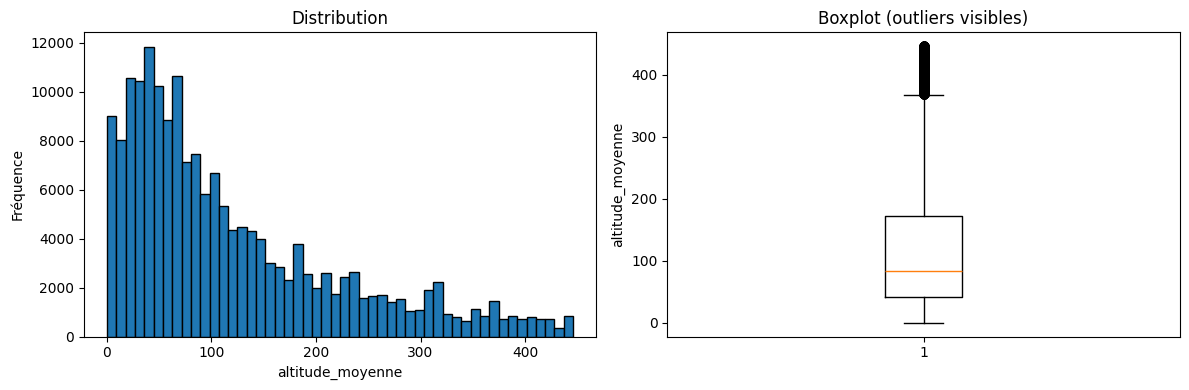

In [31]:
for col in df_merged_clean:
    visu_outliers(df_merged_clean[col])


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

y = df_merged['Valeur fonciere']
X = df_merged.drop(columns=['Valeur fonciere'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42))
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)

r2 = r2_score(y_valid, preds)
print(f"R2 = {r2:.4f}")

R2 = 0.4374


Visualisation des outliers pour la variable Valeur fonciere

Min: 2, Max: 124971904
Médiane: 178275.0, Moyenne: 247849.2869370273


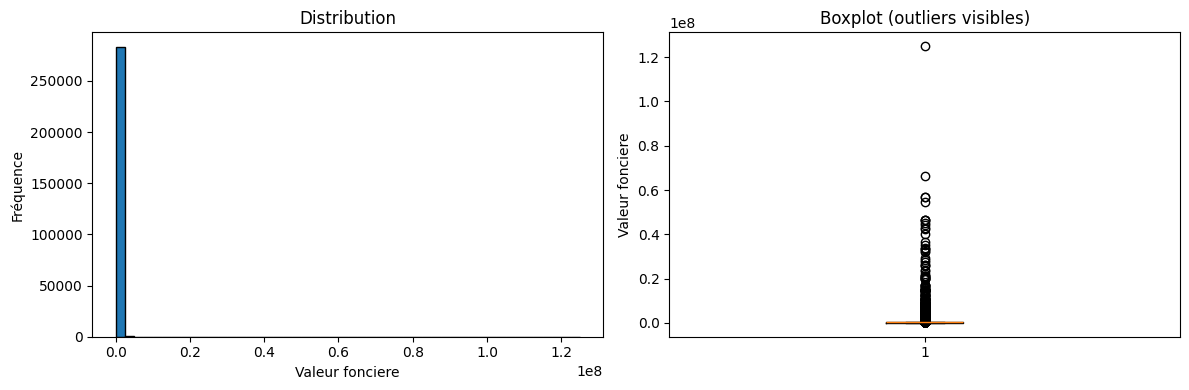

Visualisation des outliers pour la variable Valeur fonciere

Min: 5, Max: 540000
Médiane: 161000.0, Moyenne: 182184.52741450781


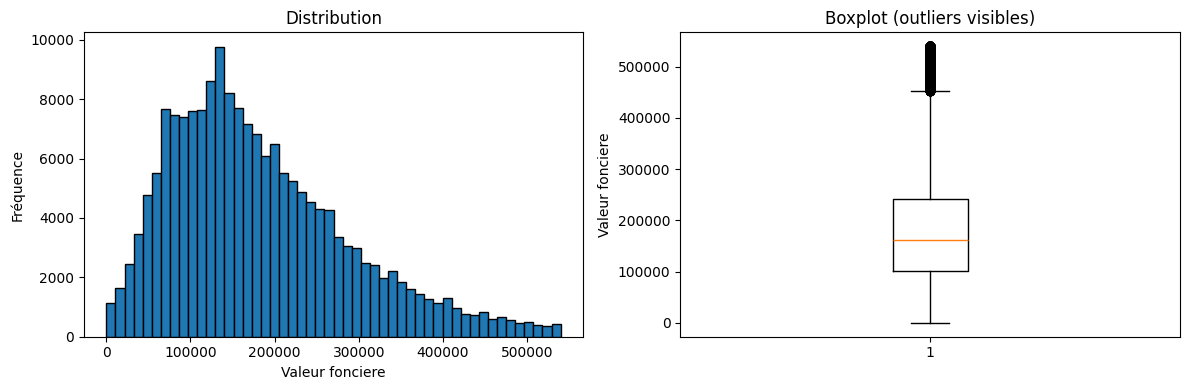

Visualisation des outliers pour la variable Surface reelle bati

Min: 1, Max: 303623
Médiane: 73.0, Moyenne: 98.97087341054906
Médiane: 73.0, Moyenne: 98.97087341054906


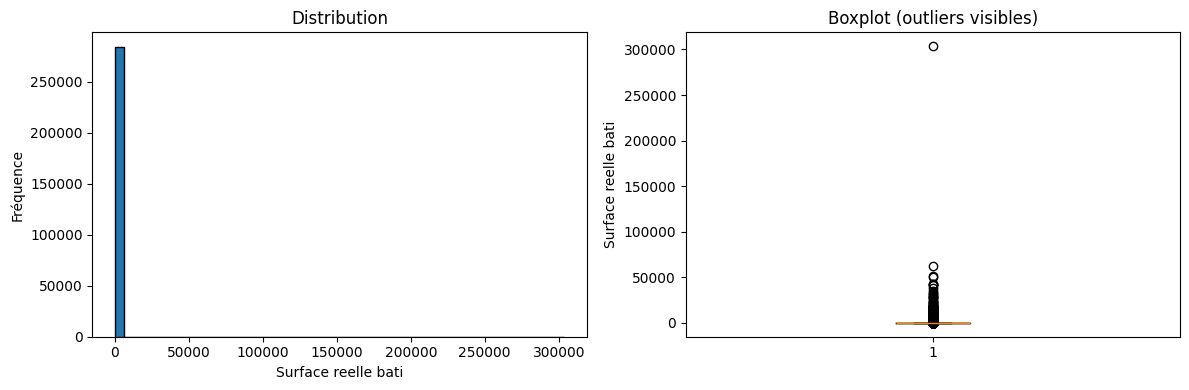

Visualisation des outliers pour la variable Surface reelle bati

Min: 1, Max: 172
Médiane: 74.0, Moyenne: 75.42159733021933


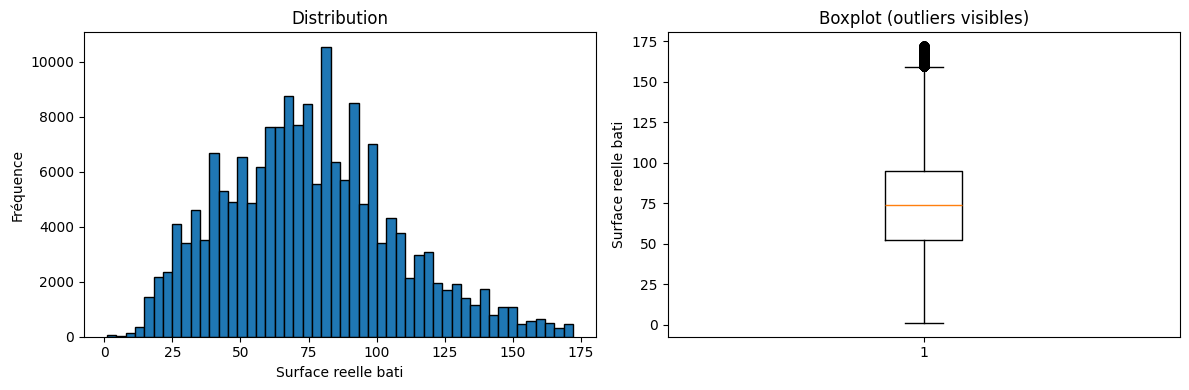

Visualisation des outliers pour la variable Nombre pieces principales

Min: 0, Max: 83
Médiane: 3.0, Moyenne: 3.194320385445152


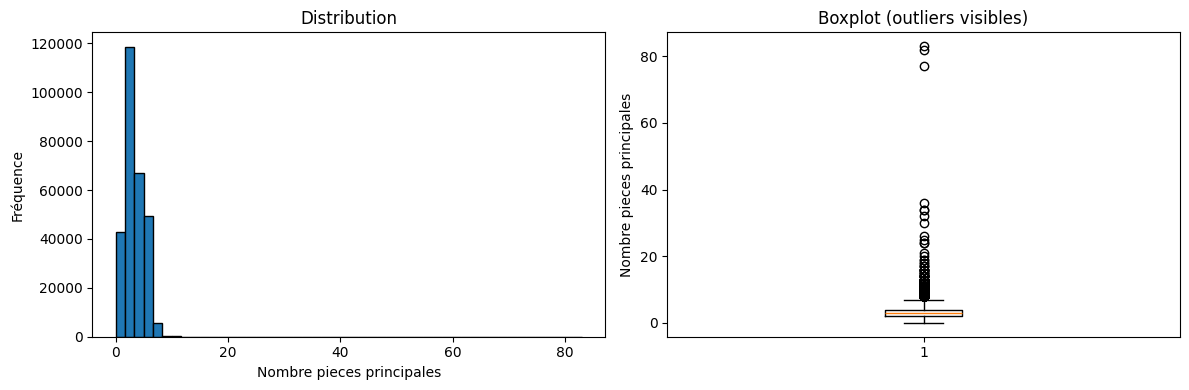

Visualisation des outliers pour la variable Nombre pieces principales

Min: 0, Max: 7
Médiane: 3.0, Moyenne: 3.2898128829093083


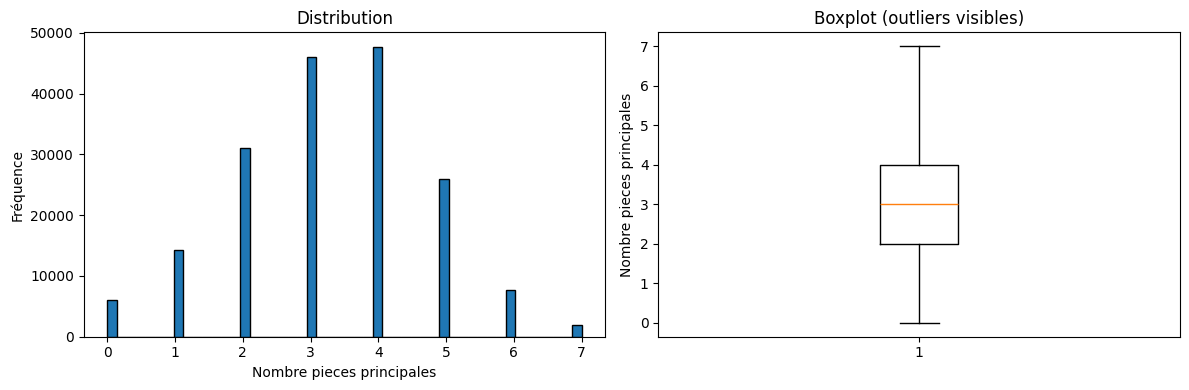

Visualisation des outliers pour la variable Surface terrain

Min: 0, Max: 263590
Médiane: 0.0, Moyenne: 281.8668116661212


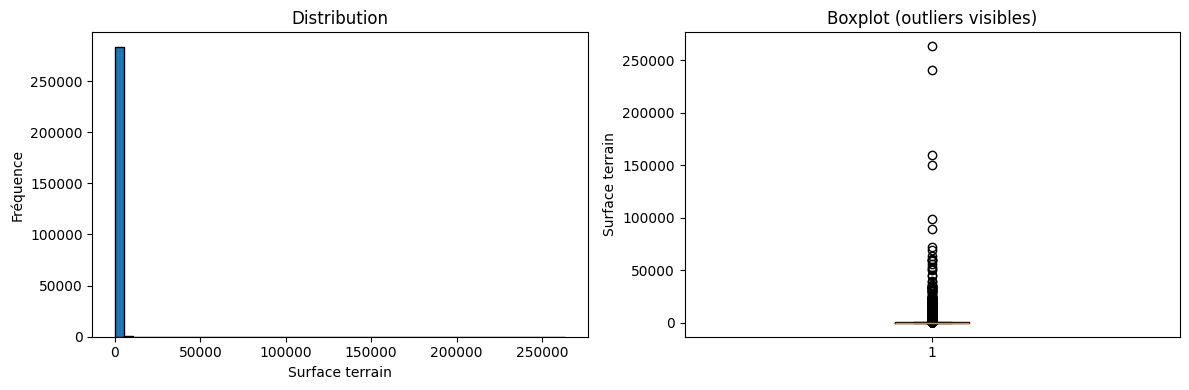

Visualisation des outliers pour la variable Surface terrain

Min: 0, Max: 1000
Médiane: 65.0, Moyenne: 215.1823243252218


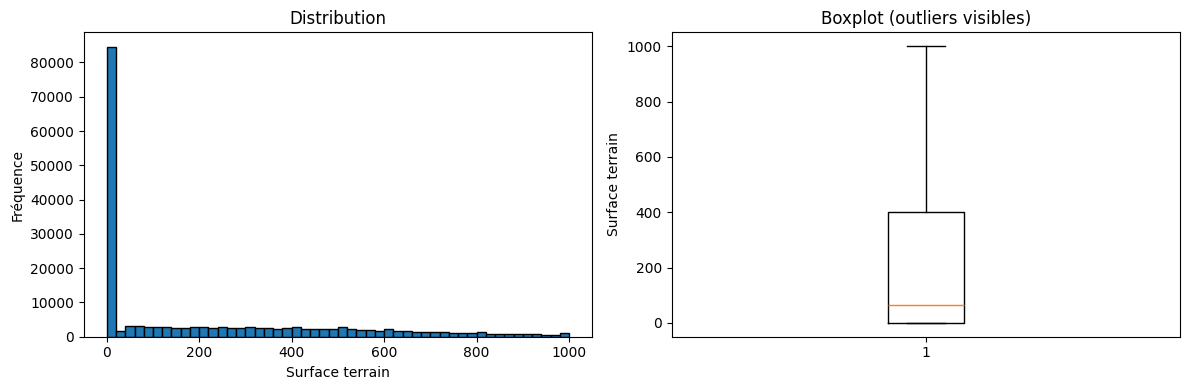

Visualisation des outliers pour la variable population

Min: 10, Max: 2133111
Médiane: 14411.0, Moyenne: 145475.62540517142


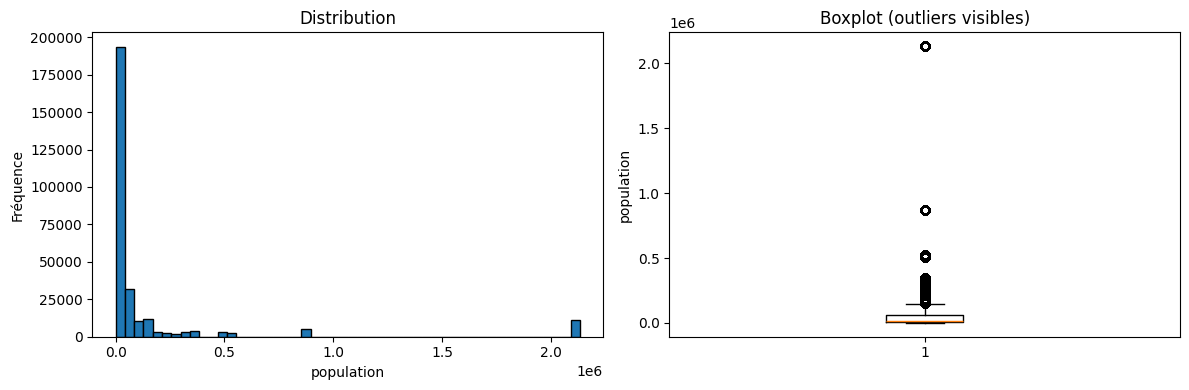

Visualisation des outliers pour la variable population

Min: 18, Max: 147327
Médiane: 10369.0, Moyenne: 24390.28973540171
Médiane: 10369.0, Moyenne: 24390.28973540171


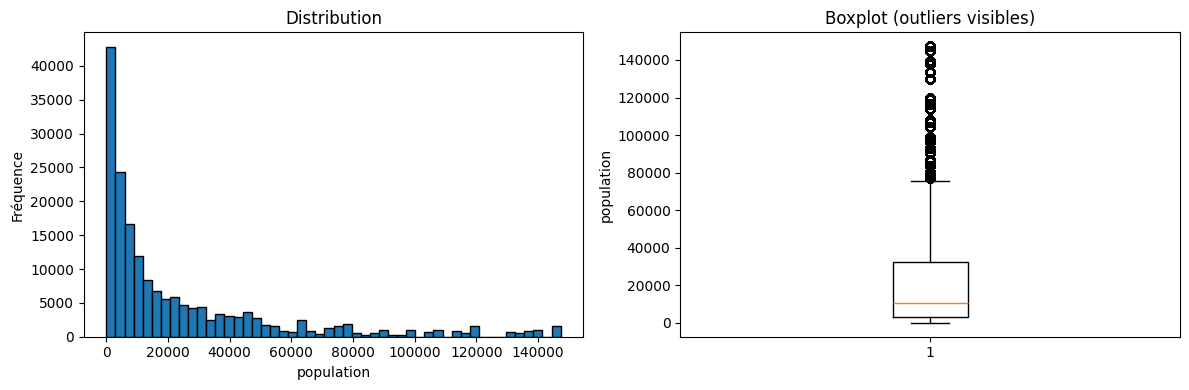

Visualisation des outliers pour la variable superficie_km2

Min: 0, Max: 758
Médiane: 20.0, Moyenne: 36.9287355836404


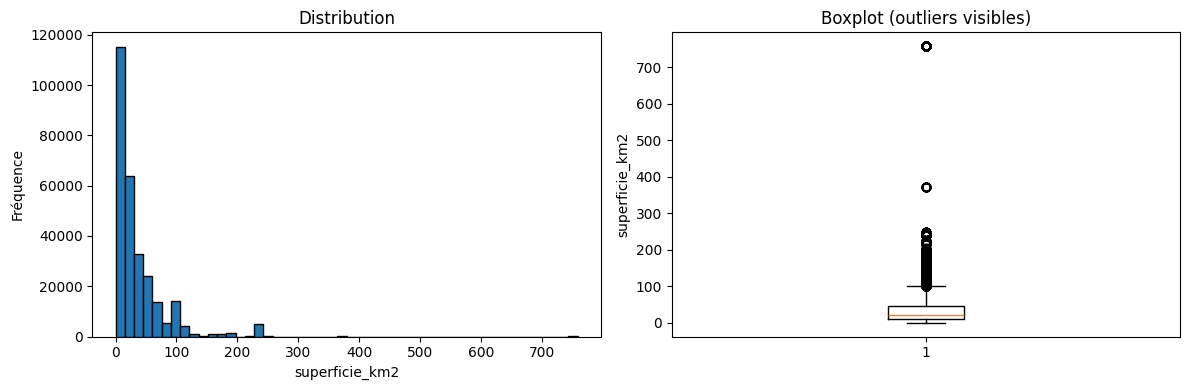

Visualisation des outliers pour la variable superficie_km2

Min: 0, Max: 100
Médiane: 16.0, Moyenne: 22.91914283658662


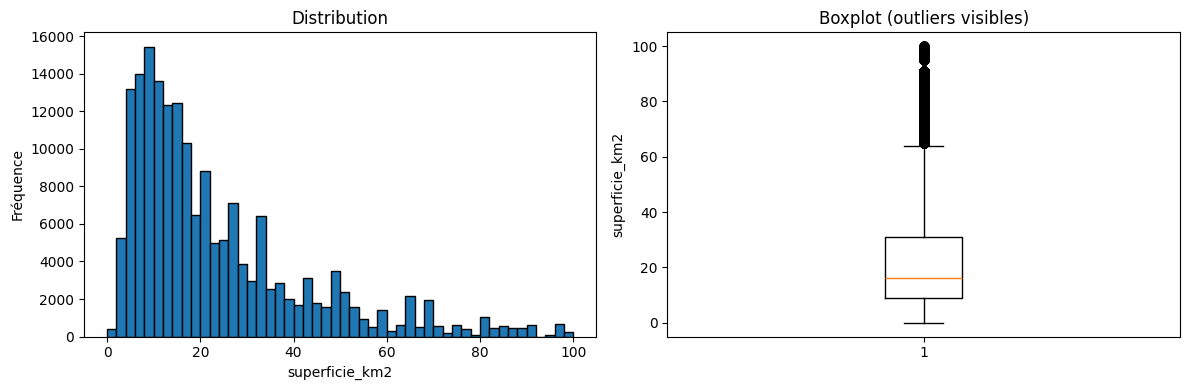

Visualisation des outliers pour la variable densite

Min: 0.0, Max: 28220.0
Médiane: 833.0, Moyenne: 2870.419456674374


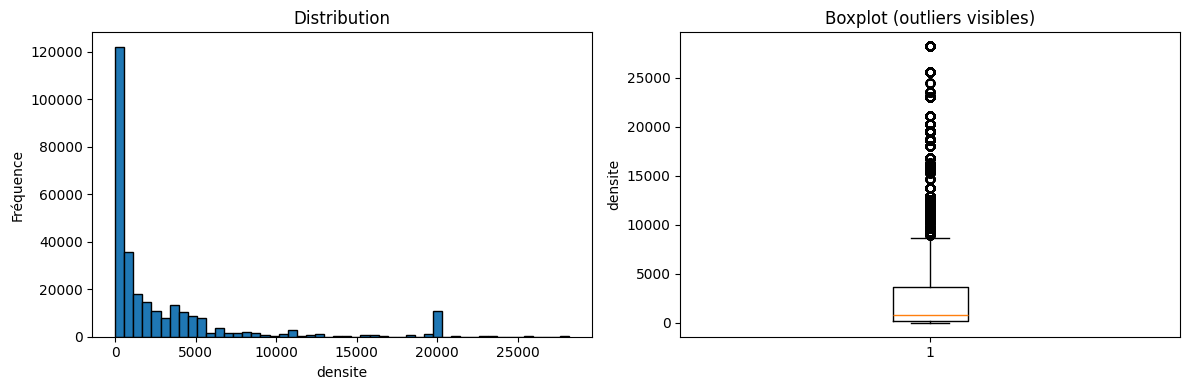

Visualisation des outliers pour la variable densite

Min: 2.0, Max: 8640.0
Médiane: 659.0, Moyenne: 1437.9316947904963


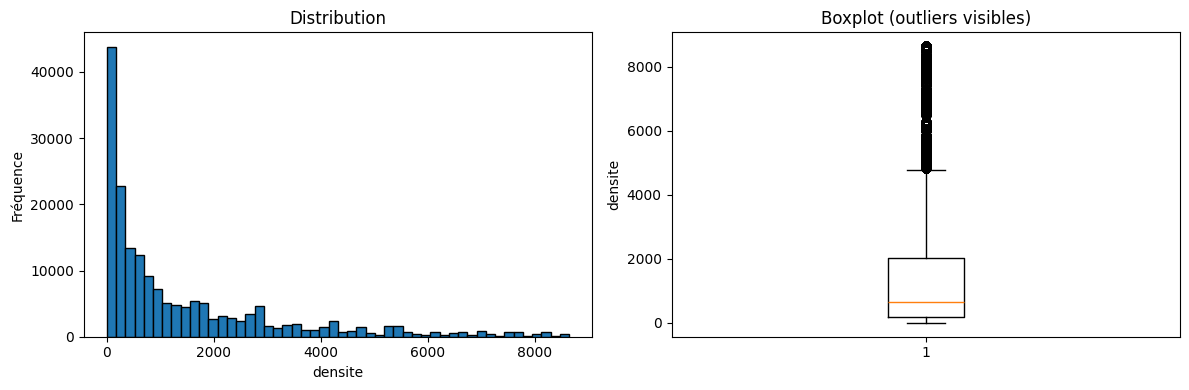

Visualisation des outliers pour la variable niveau_equipements_services

Min: 0.0, Max: 4.0
Médiane: 3.0, Moyenne: 2.484069416729136


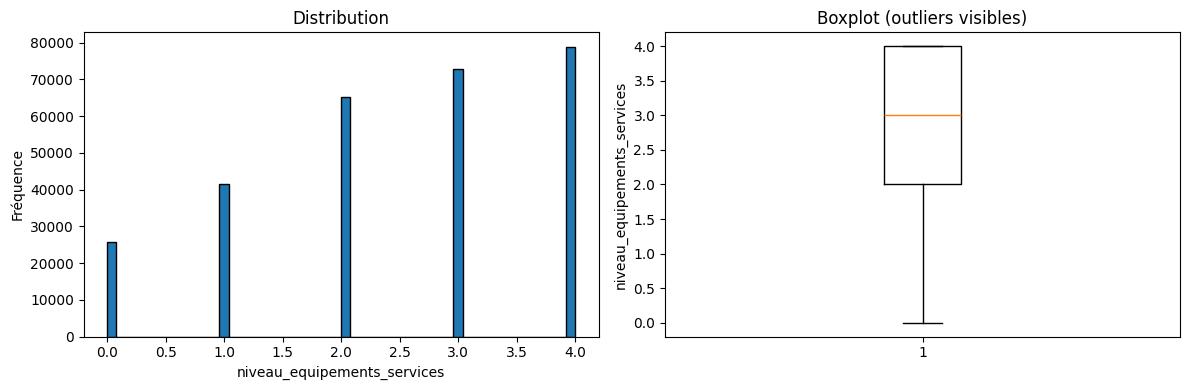

Visualisation des outliers pour la variable niveau_equipements_services

Min: 0.0, Max: 4.0
Médiane: 2.0, Moyenne: 2.303355489266087


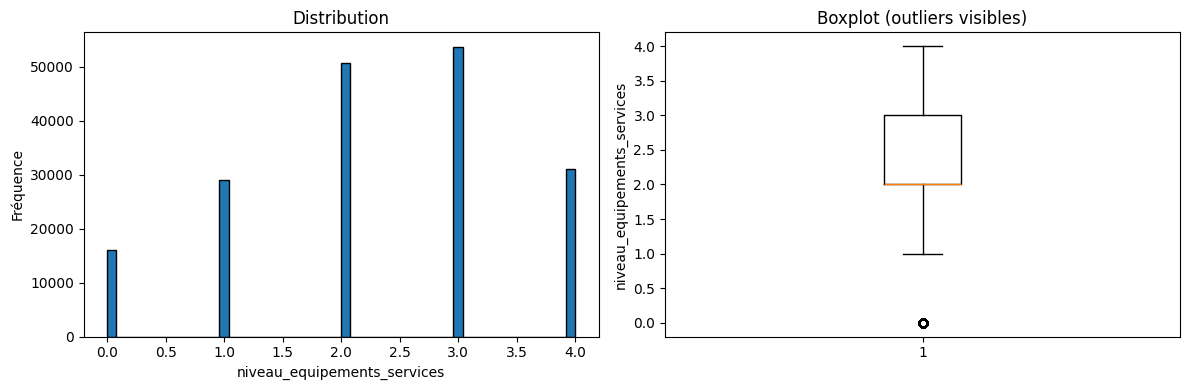

Visualisation des outliers pour la variable latitude_centre

Min: 42.356, Max: 51.073
Médiane: 46.976, Moyenne: 46.668151163691014


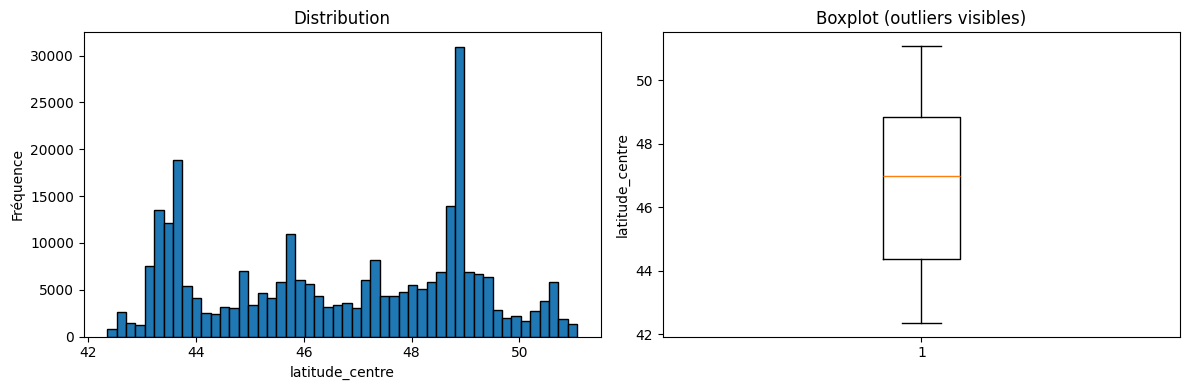

Visualisation des outliers pour la variable latitude_centre

Min: 42.444, Max: 51.073
Médiane: 47.381, Moyenne: 46.92768485630005


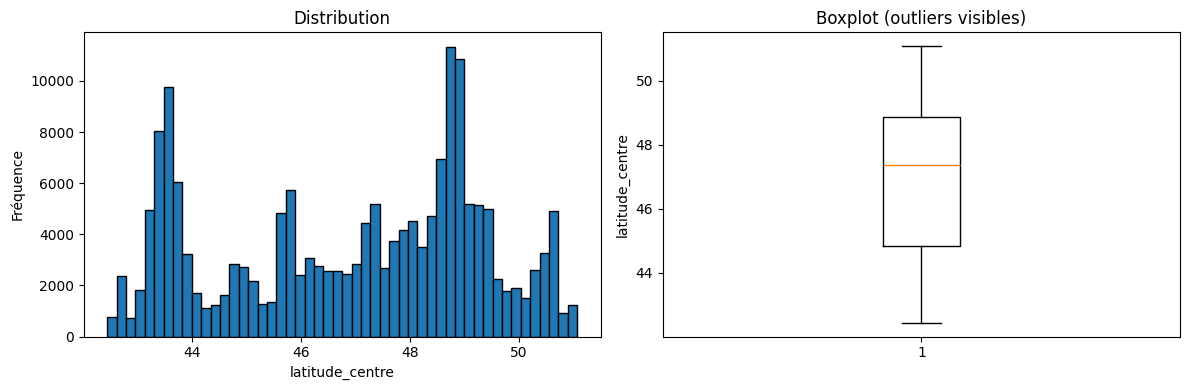

Visualisation des outliers pour la variable longitude_centre

Min: -5.085, Max: 7.652
Médiane: 2.448, Moyenne: 2.5319164018314977


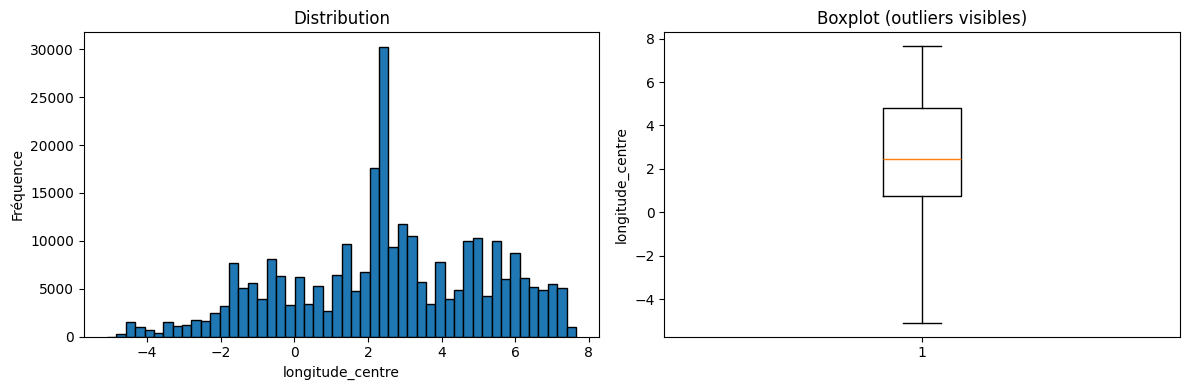

Visualisation des outliers pour la variable longitude_centre

Min: -5.085, Max: 7.494
Médiane: 2.356, Moyenne: 2.1334488491275065


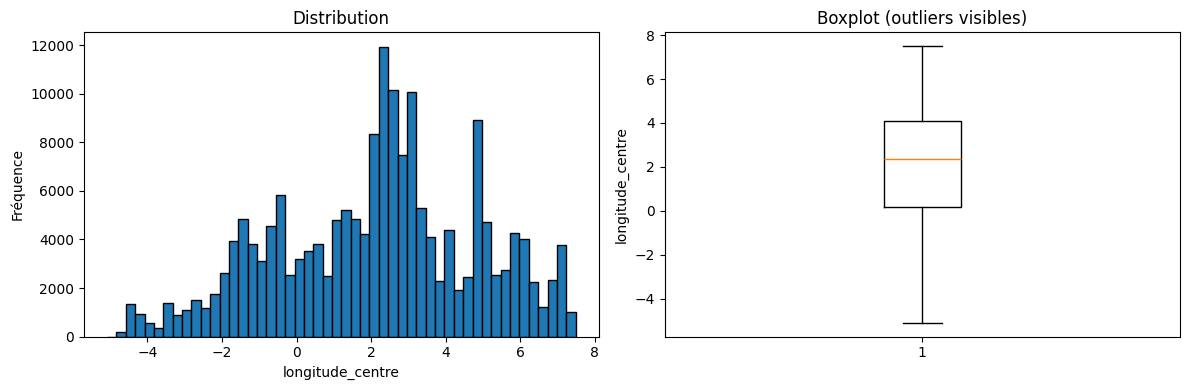

Visualisation des outliers pour la variable altitude_moyenne

Min: 0, Max: 2713
Médiane: 91.0, Moyenne: 180.83466190843214


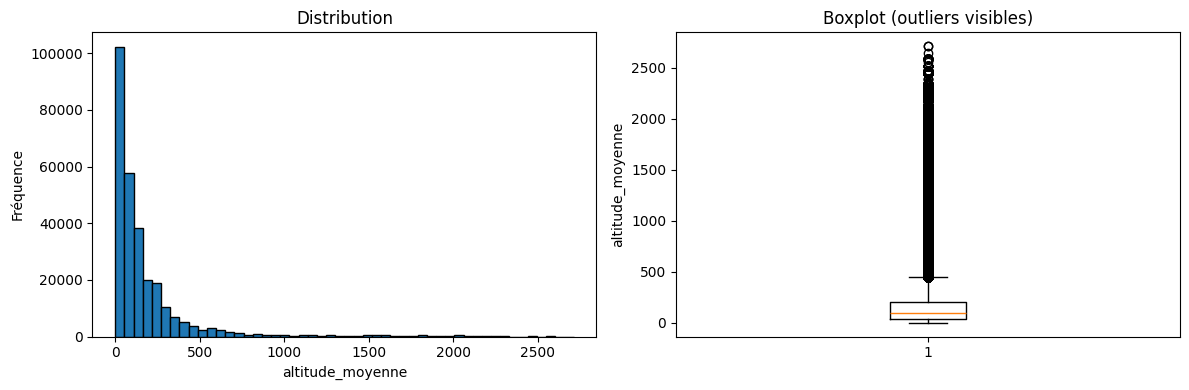

Visualisation des outliers pour la variable altitude_moyenne

Min: 0, Max: 446
Médiane: 84.0, Moyenne: 119.24048503229305


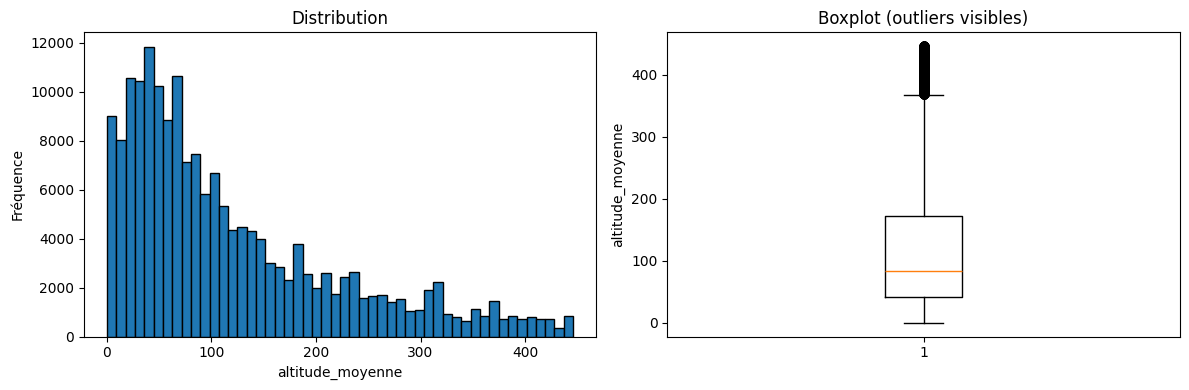

In [35]:
for col in df_merged_clean:
    visu_outliers(df_merged[col])
    visu_outliers(df_merged_clean[col])


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

y = df_merged_clean['Valeur fonciere']
X = df_merged_clean.drop(columns=['Valeur fonciere'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42))
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)

r2 = r2_score(y_valid, preds)
print(f"R2 = {r2:.4f}")

R2 = 0.5751


### api pour recup donnees de loc d'une ville

In [ ]:
import requests

def get_commune_info(name_or_code):
    """
    Récupère la latitude, longitude et densité (hab/km²) d'une commune
    à partir de son nom (str) ou de son code INSEE (int).
    Utilise l'API Découpage administratif (geo.api.gouv.fr) pour les données.
    """
    try:
        # Préparer la requête selon le type d'entrée
        if isinstance(name_or_code, str):
            # Recherche par nom de commune (première correspondance)
            params = {
                'nom': name_or_code,
                'fields': 'code,centre,surface,population',
                'limit': 1
            }
            res = requests.get("https://geo.api.gouv.fr/communes", params=params, timeout=10)
            res.raise_for_status()
            communes = res.json()
            if not communes:
                print(f"Commune '{name_or_code}' non trouvée.")
                return {}
            data = communes[0]
            nom = name_or_code
            code = data.get("code")
        else:
            # Recherche par code INSEE (format 5 chiffres)
            code = f"{name_or_code:05d}"
            res = requests.get(f"https://geo.api.gouv.fr/communes/{code}",
                               params={'fields': 'nom,centre,surface,population'}, timeout=10)
            res.raise_for_status()
            data = res.json()
            nom = data.get("nom")
        # Extraire les informations utiles
        
        centre = data.get("centre")
        if not centre or "coordinates" not in centre:
            print("Coordonnées non disponibles pour la commune.")
            return {}
        
        lon, lat = centre["coordinates"]
        surface = data.get("surface")
        population = data.get("population")
        # Calcul de la densité (habitants par km²)
        densite = None
        if surface and population is not None:
            densite = population / surface
        
        return {"nom": nom, "code INSEE": code, "latitude": lat, "longitude": lon, "surface": surface, "population": population, "densite": densite}

    except requests.RequestException as e:
        print(f"Erreur réseau ou API : {e}")
        return {}

In [ ]:
for code in range(75101, 75121):
    info = get_commune_info(code)
    if info:
        df = pd.concat([df, pd.DataFrame([info])], ignore_index=True)
    time.sleep(0.2)  # petite pause pour éviter de spammer l'API

Rouziers-de-Touraine
{'nom': 'Paris 1', 'code INSEE': '81202', 'latitude': 43.7968, 'longitude': 1.8296, 'surface': 2877.08, 'population': 1009, 'densite': 0.35070279589027764}


In [ ]:
def get_commune_full_info(code_insee):
    """
    Récupère les informations complètes d'une commune via l'API geo.api.gouv.fr
    """
    try:
        res = requests.get(
            f"https://geo.api.gouv.fr/communes/{code_insee}",
            params={'fields': 'nom,code,centre,surface,population,codeDepartement,codeRegion,departement,region,codesPostaux'},
            timeout=10
        )
        res.raise_for_status()
        data = res.json()

        # Extraction des informations principales
        centre = data.get("centre", {})
        lon, lat = None, None
        if "coordinates" in centre:
            lon, lat = centre["coordinates"]

        surface = data.get("surface")
        population = data.get("population")
        densite = population / surface if surface and population else None

        return {
            "code_insee": data.get("code"),
            "nom": data.get("nom"),
            "population": population,
            "surface_km2": surface,
            "densite": densite,
            "latitude": lat,
            "longitude": lon,
            "departement": data.get("departement", {}).get("nom"),
            "code_departement": data.get("codeDepartement"),
            "region": data.get("region", {}).get("nom"),
            "code_region": data.get("codeRegion"),
            "codes_postaux": data.get("codesPostaux")
        }

    except requests.RequestException as e:
        print(f"Erreur pour {code_insee} : {e}")
        return None



In [71]:
df2.head()

,code_insee,nom_standard,population,superficie_km2,densite,altitude_moyenne,latitude_centre,longitude_centre,niveau_equipements_services
0,01001,L'Abergement-Clémenciat,832,16,53.0,242,46.153,4.926,0.0
1,01002,L'Abergement-de-Varey,267,9,29.0,483,46.009,5.428,0.0
2,01004,Ambérieu-en-Bugey,14854,24,607.0,379,45.961,5.373,3.0
3,01005,Ambérieux-en-Dombes,1897,16,118.0,290,45.996,4.912,1.0
4,01006,Ambléon,113,6,19.0,589,45.750,5.594,0.0
